# GemPy Paper Code: Likelihoods

In this notebook you will be able to see and run the code utilized to create the figures of the paper *GemPy - an open-source library for implicit geological modeling and uncertainty quantification*

In [36]:
# Importing dependencies

# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")
import gempy as gp
%matplotlib inline
from copy import copy, deepcopy
# Aux imports

import numpy as np
import pandas as pn
import matplotlib.pyplot as plt

## Uncertainty Quatification.

In this model we will explore how to create a model of GemPy with PyMC which some of the parameters are stochastic  in order to quatify the uncertainty that those parameters propagate to the final results.

We will use the same model as until now

In [2]:

geo_data = gp.create_data([-10e3,30e3,-10e3,20e3,-10e3,0],[100,50,50],
                         path_o = "input_data/paper_Orientations.csv",
                         path_i = "input_data/paper_Points.csv")
geo_data.add_interface(X=10, Y=4, Z=-7, formation='fault1')

gp.set_series(geo_data, {'fault_serie1': 'fault1','younger_serie' : 'Unconformity', 'older_serie': ('Layer1', 'Layer2')},
              order_formations= ['fault1', 'Unconformity', 'Layer2', 'Layer1'], verbose=2)

geo_data.modify_interface(9, Z = -6.4)

In [3]:
geo_data.interfaces[['X', 'Y', 'Z']] = geo_data.interfaces[['X', 'Y', 'Z']]*1000
geo_data.orientations[['X', 'Y', 'Z']] = geo_data.orientations[['X', 'Y', 'Z']]*1000

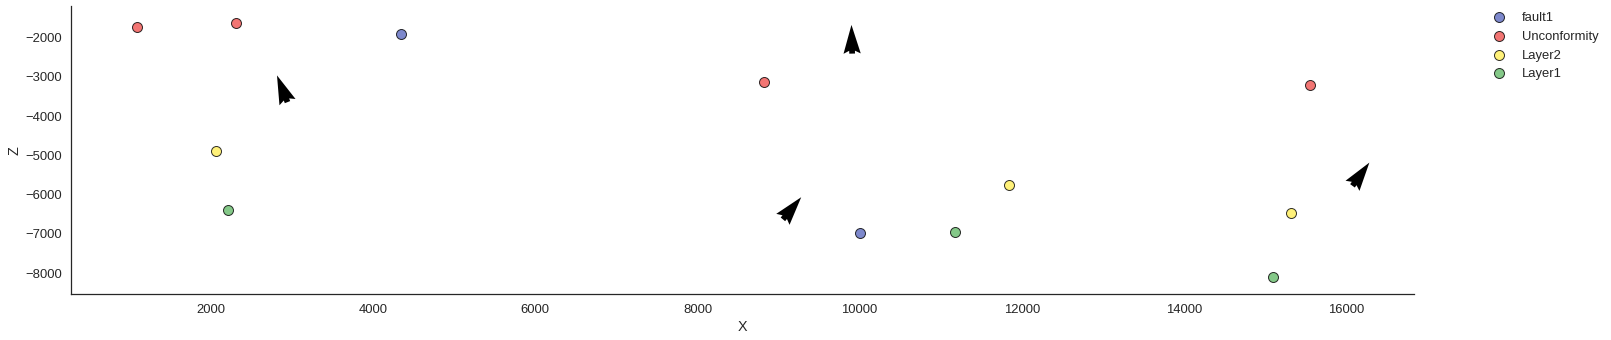

In [4]:
gp.plot_data(geo_data, direction="y")

Defining all different series that form the most complex model. In the paper you can find figures with different combination of these series to examplify the possible types of topolodies supported in GemPy

In [5]:
interp_data = gp.InterpolatorData(geo_data, dtype='float64', output='gravity', compile_theano=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64


In [6]:
# Set the specific parameters for the measurement grid of gravity:
gp.set_geophysics_obj(interp_data,  
                      [0.1e3,19.9e3,.1e3,.9e3, -10e3, 0], # Extent
                      [30,20])                            # Resolution 

In [7]:
# Setting desity and precomputations 
t = gp.precomputations_gravity(interp_data, 25,
                         [2.92e6, 3.1e6, 2.61e6, 2.92e6])

Computing the model

In [8]:
lith, fault, grav_i = gp.compute_model(interp_data, output='gravity')

## Topology

compute the initial topology for use in the topology likelihood function

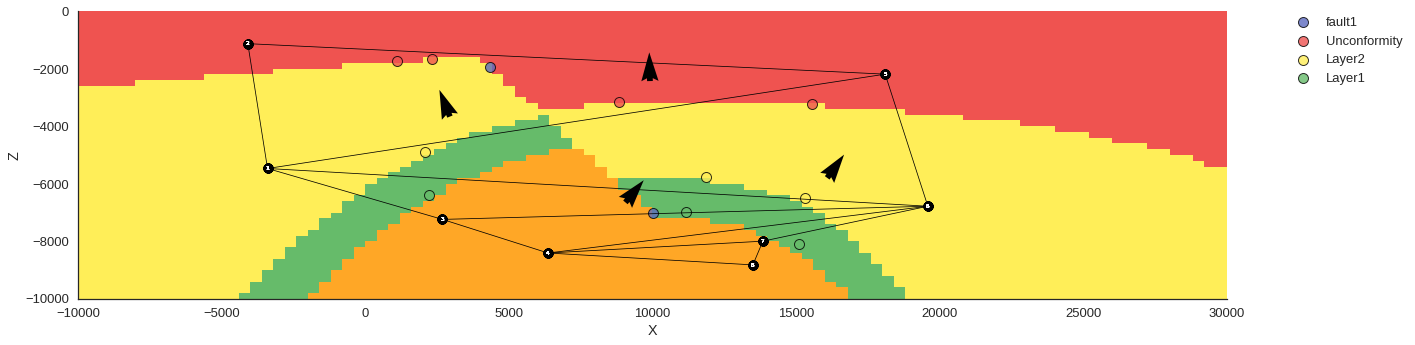

In [11]:
topo = gp.topology_compute(geo_data, lith[0], fault)
gp.plot_section(geo_data, lith[0],20, plot_data=True, direction='y')
gp.topology_plot(geo_data, topo[0], topo[1])
# plt.xlim(0, 19000)
# plt.ylim(-10000, 0)
# save topology state for likelihood use
topo_G = copy(topo[0])

## Gravity

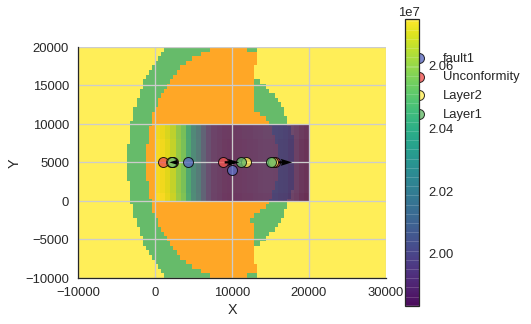

In [12]:
gp.plot_section(geo_data, lith[0], 5, direction='z',plot_data=True)
#annotate_plot(gp.get_data(geo_data_g, verbosity=2), 'annotations', 'X', 'Z', size = 20)
# ax = plt.gca()
# ax.set_xticks(np.linspace(0, 20, 50))
# ax.set_yticks(np.linspace(0, -10, 50))
plt.grid()
fig = plt.gcf()
ax = plt.gca()
p = ax.imshow(grav_i.reshape(20,30), cmap='viridis', origin='lower', alpha=0.8, extent=[0,20e3,0,10e3])
# plt.xlim(-2e3,22e3)
# plt.ylim(-2e3,12e3)

plt.xlim(-10e3,30e3)
plt.ylim(-10e3,20e3)

plt.colorbar(p)
#plt.show()

In [14]:
original_grav = np.load('input_data/real_grav.npy')

In [15]:
diff = original_grav*10**-7 - grav_i*10**-7

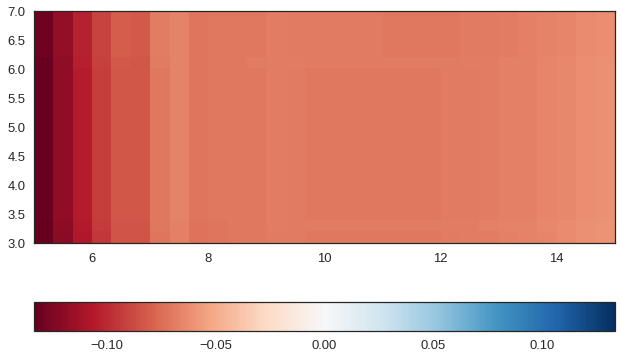

In [17]:
plt.imshow(diff.reshape(20,30), cmap='RdBu', origin='lower', extent=[5,15,3,7], vmin = diff.min(),
           vmax=-diff.min())
plt.colorbar(orientation='horizontal')

# PYMC2 Code

In [18]:
import pymc

## Priors

In [19]:
geo_data.interfaces.head()

X       Y         Z     formation         series  order_series  \
0   4345.153  5000.0 -1921.564        fault1   fault_serie1             1   
1  10000.000  4000.0 -7000.000        fault1   fault_serie1             1   
2   2303.022  5000.0 -1647.248  Unconformity  younger_serie             2   
3   1083.840  5000.0 -1738.687  Unconformity  younger_serie             2   
4   8825.648  5000.0 -3140.747  Unconformity  younger_serie             2   

   isFault  formation_number                       annotations  
0     True                 1  ${\bf{x}}_{\alpha \,{\bf{1}},0}$  
1     True                 1  ${\bf{x}}_{\alpha \,{\bf{1}},1}$  
2    False                 2  ${\bf{x}}_{\alpha \,{\bf{2}},0}$  
3    False                 2  ${\bf{x}}_{\alpha \,{\bf{2}},1}$  
4    False                 2  ${\bf{x}}_{\alpha \,{\bf{2}},2}$

In [20]:
#from gempy.UncertaintyAnalysisPYMC2 import modify_plane_dip
from copy import deepcopy
import pymc

First we store the original object with the data (rescaled)

In [21]:
geo_data_stoch_init = deepcopy(interp_data.geo_data_res)

In [22]:
interp_data.geo_data_res.interfaces.tail()

X         Y         Z formation       series  order_series  \
7   0.608836  0.516771  0.470629    Layer2  older_serie             3   
8   0.724688  0.516771  0.446239    Layer2  older_serie             3   
9   0.287701  0.516771  0.449356    Layer1  older_serie             3   
10  0.586478  0.516771  0.429979    Layer1  older_serie             3   
11  0.717574  0.516771  0.392378    Layer1  older_serie             3   

    isFault  formation_number                       annotations  
7     False                 3  ${\bf{x}}_{\alpha \,{\bf{3}},1}$  
8     False                 3  ${\bf{x}}_{\alpha \,{\bf{3}},2}$  
9     False                 4  ${\bf{x}}_{\alpha \,{\bf{4}},0}$  
10    False                 4  ${\bf{x}}_{\alpha \,{\bf{4}},1}$  
11    False                 4  ${\bf{x}}_{\alpha \,{\bf{4}},2}$

The first step is to define the pdf which describe our priors. In this case we will add noise to the interfaces of 0.3 (0.01 rescaled).

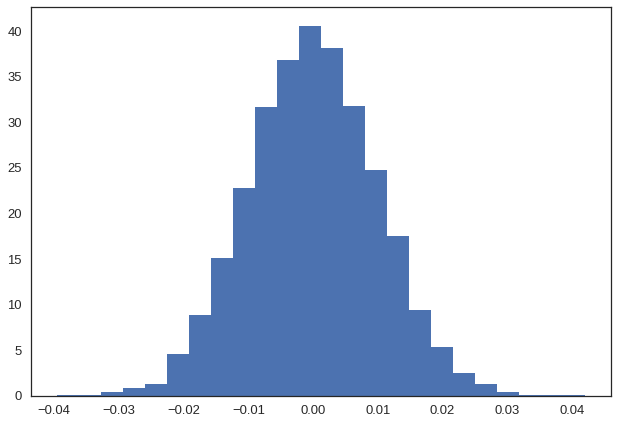

In [23]:
# Positions (rows) of the data we want to make stochastic
ids = range(2,12)

# List with the stochastic parameters 
interface_Z_modifier = [pymc.Normal("interface_Z_mod_"+str(i), 0., 1./0.01**2) for i in ids]

# Plotting the first element of the list
samples = [interface_Z_modifier[0].rand() for i in range(10000)]
plt.hist(samples, bins=24, normed=True);

To store the value of the input data---i.e. the value x at every each iteration---we need to wrap the process inside a detereministic decorator of pymc2:

## Deterministic functions

In [25]:
@pymc.deterministic(trace=True)
def input_data(value = 0, 
               interface_Z_modifier = interface_Z_modifier,
               geo_data_stoch_init = geo_data_stoch_init,
               ids = ids,
               verbose=0):
    # First we extract from our original intep_data object the numerical data that is necessary for the interpolation.
    # geo_data_stoch is a pandas Dataframe
    geo_data_stoch = gp.get_data(geo_data_stoch_init, numeric=True)
    
    # Now we loop each id which share the same uncertainty variable. In this case, each layer.
    for num, i in enumerate(ids):
        # We add the stochastic part to the initial value
        interp_data.geo_data_res.interfaces.set_value(i, "Z", geo_data_stoch_init.interfaces.iloc[i]["Z"] + interface_Z_modifier[num])
        
    if verbose > 0:
        print(geo_data_stoch)
        
    # then return the input data to be input into the modeling function. Due to the way pymc2 stores the traces
    # We need to save the data as numpy arrays
    return [interp_data.geo_data_res.interfaces[["X", "Y", "Z"]].values,
            interp_data.geo_data_res.orientations[["G_x", "G_y", "G_z", "X", "Y", "Z", 'dip', 'azimuth', 'polarity']].values]

In [27]:
# %matplotlib notebook
@pymc.deterministic(trace=False)
def gempy_model(value=0,
                input_data=input_data, verbose=False):
    
    # modify input data values accordingly
    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
    
    # Gx, Gy, Gz are just used for visualization. The theano function gets azimuth dip and polarity!!!
    interp_data.geo_data_res.orientations[["G_x", "G_y", "G_z", "X", "Y", "Z", 'dip', 'azimuth', 'polarity']] = input_data[1]
    
    try:
        # try to compute model
        lb, fb, grav = gp.compute_model(interp_data, output='gravity')
        if verbose:
            gp.plot_section(interp_data.geo_data_res, lb[0], 5, plot_data=False)
           # gp.plot_data(interp_data.geo_data_res, direction='y')

        return lb, fb, grav
    
    except np.linalg.linalg.LinAlgError as err:
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose:
            print("Exception occured.")
        return np.zeros_like(lith), np.zeros_like(fault), np.zeros_like(grav_i)

In [38]:
@pymc.deterministic(trace=True)
def gempy_surfaces(value=0, gempy_model=gempy_model):
    vert, simp = gp.get_surfaces(interp_data, gempy_model[0][1], gempy_model[1][1], original_scale=True)
    
    return vert

In [39]:
@pymc.deterministic(trace=True)
def gempy_topo(value=0, gm=gempy_model, verbose=False):
    G, c, lu, lot1, lot2 = gp.topology_compute(geo_data, gm[0][0], gm[1], cell_number=0, direction="y")
    
    if verbose:
        gp.plot_section(geo_data, gm[0][0], 0)
        gp.topology_plot(geo_data, G, c)
    
    return G, c, lu, lot1, lot2

In [40]:
@pymc.deterministic
def e_sq(value = original_grav, model_grav = gempy_model[2], verbose = 0):
    square_error =  np.sqrt(np.sum((value*10**-7 - (model_grav*10**-7))**2)) 
  #  print(square_error)
    return square_error



## Likelihood functions

In [42]:
@pymc.stochastic
def like_topo_jaccard_cauchy(value=0, gempy_topo=gempy_topo, G=topo_G):
    """Compares the model output topology with a given topology graph G using an inverse Jaccard-index embedded in a half-cauchy likelihood."""
    j = gp.topology.compare_graphs(G, gempy_topo[0])  # jaccard-index comparison
    return pymc.half_cauchy_like(1 - j, 0, 0.001)  # the last parameter adjusts the "strength" of the likelihood

In [43]:
@pymc.observed
def inversion(value = 1, e_sq = e_sq):
    return pymc.half_cauchy_like(e_sq,0,0.1)

## pymc Model

In [44]:
# We add all the pymc objects to a list
params = [input_data, gempy_model, gempy_surfaces, gempy_topo, *interface_Z_modifier,
          like_topo_jaccard_cauchy, e_sq, inversion] 

# We create the pymc model i.e. the probabilistic graph
model = pymc.Model(params)

Create pymc probabilistic graph plot:

In [47]:
graph = pymc.graph.dag(model, path = 'figures/')
graph.write_png('figures/paper_graph_like.png')

True

Running inference:

In [29]:
runner = pymc.MCMC(model, db="hdf5", dbname="pymc-db/paper_like.hdf5")

In [30]:
#iterations = 1000

In [ ]:
runner.use_step_method(pymc.AdaptiveMetropolis, params, delay=1000)
runner.sample(iter = 20000, burn=1000, thin=20, tune_interval=1000, tune_throughout=True)

Computing the initial model:

In [ ]:
post = gp.pa.Posterior("paper_like.hdf5")

In [68]:
geo_data_p = gp.create_data([0,20e3,0, 10e3,-10e3,0],[100,10,100],
                         path_f = "input_data/paper_Orientations.csv",
                         path_i = "input_data/paper_Points.csv")
geo_data_p.add_interface(X=10, Y=4, Z=-7, formation='fault1')

gp.set_series(geo_data_p, {'fault_serie1': 'fault1','younger_serie' : 'Unconformity', 'older_serie': ('Layer1', 'Layer2')},
              order_formations= ['fault1', 'Unconformity', 'Layer2', 'Layer1'], verbose=2)

geo_data_p.modify_interface(9, Z = -6.4)

geo_data_p.interfaces[['X', 'Y', 'Z']] = geo_data_p.interfaces[['X', 'Y', 'Z']]*1000
geo_data_p.orientations[['X', 'Y', 'Z']] = geo_data_p.orientations[['X', 'Y', 'Z']]*1000

In [116]:
interp_datap_p = gp.InterpolatorInput(geo_data_p, dtype='float64')

Level of Optimization:  fast_run
Device:  cpu
Precision:  float64


In [130]:
post.change_input_data(interp_datap_p, 940)

In [131]:
lb_p, fb_p = gp.compute_model(interp_datap_p)

In [132]:
gp.plot_section(interp_datap_p.geo_data_res, lb_p[0], 5, plot_data=True)

In [139]:
post.n_iter = 949

In [133]:
v_l, s_l = gp.get_surfaces(interp_datap_p, lb_p[1], fb_p[1], original_scale=True)

In [140]:
ver, sim = gp.get_surfaces(interp_datap_p,lb_p[1], fb_p[1], original_scale= False)
gp.plot_surfaces_3D_real_time(interp_datap_p, ver, sim, posterior=post, alpha=1)

In [77]:
gp.plot_surfaces_3D(geo_data, v_l, s_l, alpha=1)

In [163]:
lith_list = np.zeros((0, lb_p[0].shape[-1]), dtype='int')
vertices_list = []

for i in range(post.n_iter):
    post.change_input_data(interp_datap_p, i)
    lb_p, fb_p = gp.compute_model(interp_datap_p)
    lith_list = np.vstack((lith_list,lb_p[0]))
    v_l, s_l = gp.get_surfaces(interp_datap_p, lb_p[1], fb_p[1], original_scale=True)
    vertices_list.append(v_l)

In [43]:
vertices = post.db.trace("gempy_surfaces")[:]


In [165]:
vertices = vertices_list

Reading traces:

In [186]:
# Some plotting options
params = {
    'axes.labelsize': 6,
    'font.size': 6,
    'legend.fontsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'text.usetex': False,
    "axes.linewidth": 0.75,
    'xtick.major.size': 2,
    'xtick.major.width': 0.75,
    'ytick.major.size': 2,
    'ytick.major.width': 0.75,
}


def get_figsize(scale, textwidth=522, ratio=None):                      # Get this from LaTeX using \the\textwidth
    """Source: http://bkanuka.com/articles/native-latex-plots/"""
    inches_per_pt = 1.0 / 72.27                             # Convert pt to inch
    if ratio == None:
        ratio = (np.sqrt(5.0)-1.0)/2.0                    # Aesthetic ratio (you could change this)
    fig_width = textwidth * inches_per_pt * scale           # width in inches
    fig_height = fig_width * ratio                    # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size

from matplotlib import rcParams
rcParams.update(params)

In [199]:
# Choosing vertices to plot
np.array(vertices[0][1][:,1] > 4800) * np.array(vertices[0][1][:,1] < 5200)

array([False, False, False, ..., False, False, False], dtype=bool)

In [200]:
# Function to plot the traces with the vertices
def plot_iterline(i, l, color="black", lw=0.5):
 
    f = np.array(vertices[i][l][:,1] > 4800) * np.array(vertices[i][l][:,1] < 5200)
    points = vertices[i][l][f]
    plt.plot(points[::3,0], points[::3,2], '-',
             linewidth=lw, color=color, alpha=0.05)


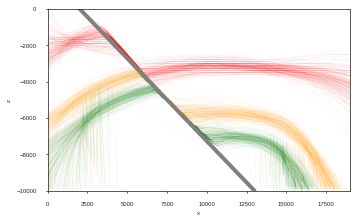

In [209]:
fig = plt.figure(figsize=get_figsize(0.75))
ax = plt.subplot()
    
for i in range(0,950,5):
    plot_iterline(i, 3, color="green")
    plot_iterline(i, 2, color="orange")
    plot_iterline(i, 1, color="red")
    # plot_iterline(i, 0, color="black", lw=2)
    
ax.set_xlabel("x")

plt.legend()
plt.ylabel("z")
plt.xlim(0,19000)
#ax.set_xticks(np.arange(0, 20, 5))
plt.ylim(-10000,-0)
plt.plot([2000., 13000], [0,-10000], color="gray", linewidth=4)
plt.grid(False)

# plt.savefig("doc/figs/like.pdf", facecolor="white")

In [ ]:
gp.plot_section(geo_data, runner.trace("gempy_model")[:][:,0,0,:][2], 5)

In [202]:
p_i = uq.compute_prob_lith(lith_list)

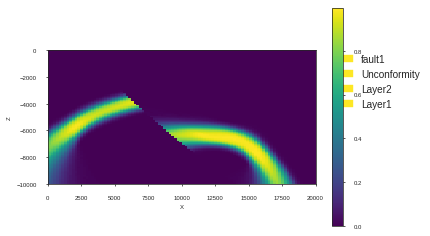

In [208]:
gp.plot_section(geo_data_p,p_i[3], 5, cmap='viridis', norm=None)
plt.colorbar()

#plt.savefig("doc/figs/prob.pdf", facecolor="white")

In [205]:
e = gp.pa.calcualte_ie_masked(p_i)

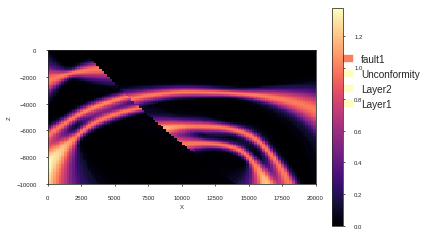

In [206]:
gp.plot_section(geo_data_p,e, 5, cmap='magma', norm=None)
plt.colorbar()
#plt.savefig("doc/figs/entropy.pdf", facecolor="white")